In [54]:
import sys
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [55]:
#11 用人工神经网络建立复杂函数模型
#11.1.3利用前向传播激活神经网络
#我们可以将多层感知机的学习过程总结为如下三个步骤：1.从输入层开始，将训练数据输入网络，前向传播训练数据以生成输出数据
#2.基于网络的输出计算损失函数值；3.使用损失函数值计算反向传播，求出损失函数对网络中每个权重和偏置的导数，并更新模型参数

In [56]:
#11.2识别手写数字
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [57]:
#归一化
X = ((X / 255.) - .5) * 2

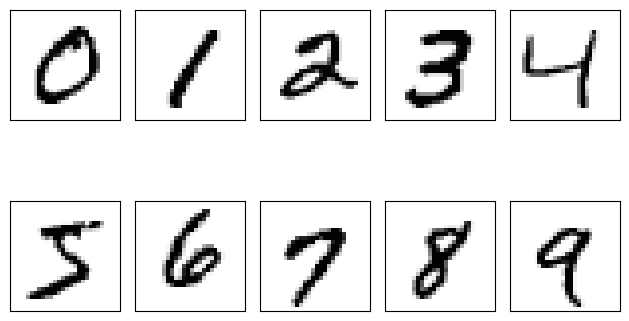

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()   #ax.flatten使图片可以直接按行存储
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

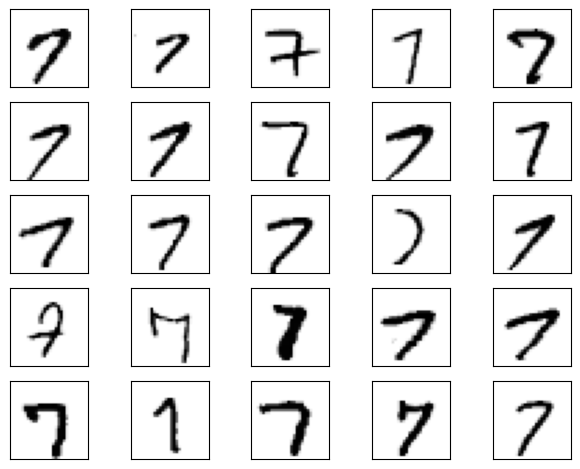

In [59]:
# Visualize 25 different versions of "7":

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [60]:
# Split into training（训练集）, validation（验证集）, and test（测试集） set:

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

In [61]:
#sigmoid函数
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

#独热编码：是一种用于处理分类变量的编码方法，它将一个分类变量转换成一个二进制向量，其中每个类别对应一个唯一的二进制编码。每个类别被表示为一个稀疏向量，其中只有一个元素为1，其余为0，表示该类别的存在或缺失
def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

In [62]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features)) #建立一个hidden*feature的正态分布随机数矩阵，50*784
        self.bias_h = np.zeros(num_hidden)  #形成一个长为hidden的全0偏置向量
        
        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))   #10*50
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h      #[55000*784]·[784*50] -> [55000 * 50]   其中55000是元素个数，此处使用了55000个元素
        a_h = sigmoid(z_h)      #e的A次方到的一个新的矩阵，新矩阵的每一项为原矩阵的e的次方

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h #最终返回LOSS函数对out层的w和b的偏导数，对hidden层的w和b偏导数

In [63]:
testA = np.array([[1, 2, 3],[4, 5, 6]])
print(testA)
eT = np.exp(testA)
eT

[[1 2 3]
 [4 5 6]]


array([[  2.71828183,   7.3890561 ,  20.08553692],
       [ 54.59815003, 148.4131591 , 403.42879349]])

In [64]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)     #实例化对象

In [65]:
### Coding the neural network training loop
# Defining data loaders:
num_epochs = 50         #迭代次数
minibatch_size = 100    
#定义小批量生成器，它可以接收数据集并将其分成所需尺寸的小批量数据，并在小批量数据上使用随机梯度下降算法训练模型
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])     #构建一个X.shape[0]大小的从0到X.shape[0]的数组，在本例中X.shape[0]是行数55000
    np.random.shuffle(indices)      #np.shuffle用于随机打乱数组中元素的排列顺序，让排列随机化

    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):       #批量处理数据
        batch_idx = indices[start_idx:start_idx + minibatch_size]       #batch_idx  是100个元素组成的行向量

        yield X[batch_idx], y[batch_idx]  #X[batch_idx]是形如(100,784)的矩阵，y[batch_idx]是长为100的标签列表

In [66]:
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [67]:
# Defining a function to compute the loss and accuracy
def mse_loss(targets, probas, num_labels=10):                   #mse指均方误差
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)      #此处将类别标签转化为独热编码标签
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

In [68]:
_, probas = model.forward(X_valid)          #使用反向传播算法更新值
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)    #选择最大值索引位置得到预测的类别标签    
acc = accuracy(y_valid, predicted_labels)       #计算准确率

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [69]:
#定义该函数通过迭代小批量数据逐步计算均方误差和准确率可以提高内存效率，此处为单次周期，即一次epoch
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/( i + 1)
    acc = correct_pred/num_examples
    return mse, acc

In [70]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


In [71]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h =                 model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [73]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid,num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.01 | Train Acc: 95.68% | Valid Acc: 94.60%
Epoch: 002/050 | Train MSE: 0.01 | Train Acc: 95.65% | Valid Acc: 94.70%
Epoch: 003/050 | Train MSE: 0.01 | Train Acc: 95.75% | Valid Acc: 94.86%
Epoch: 004/050 | Train MSE: 0.01 | Train Acc: 95.83% | Valid Acc: 94.80%
Epoch: 005/050 | Train MSE: 0.01 | Train Acc: 95.85% | Valid Acc: 94.94%
Epoch: 006/050 | Train MSE: 0.01 | Train Acc: 95.82% | Valid Acc: 94.86%
Epoch: 007/050 | Train MSE: 0.01 | Train Acc: 95.91% | Valid Acc: 94.94%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 95.98% | Valid Acc: 95.00%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 96.00% | Valid Acc: 95.10%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 96.01% | Valid Acc: 94.92%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 96.06% | Valid Acc: 94.96%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 96.10% | Valid Acc: 95.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 96.13% | Valid Acc: 95.08%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 96.15

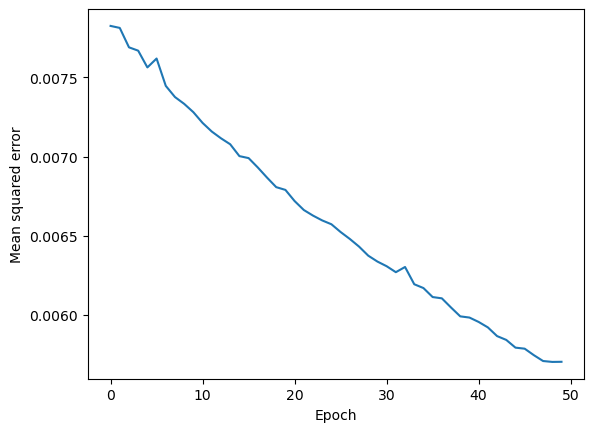

In [74]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

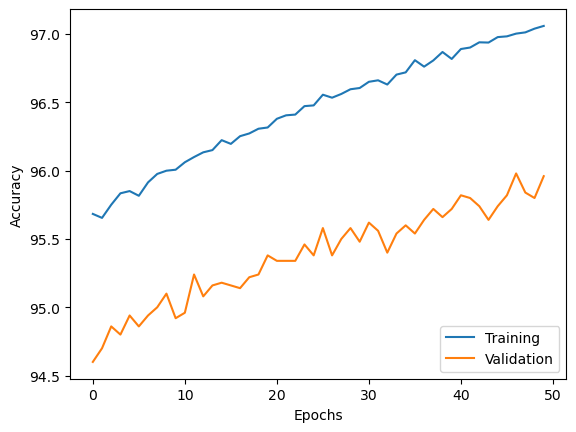

In [75]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [76]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 95.50%


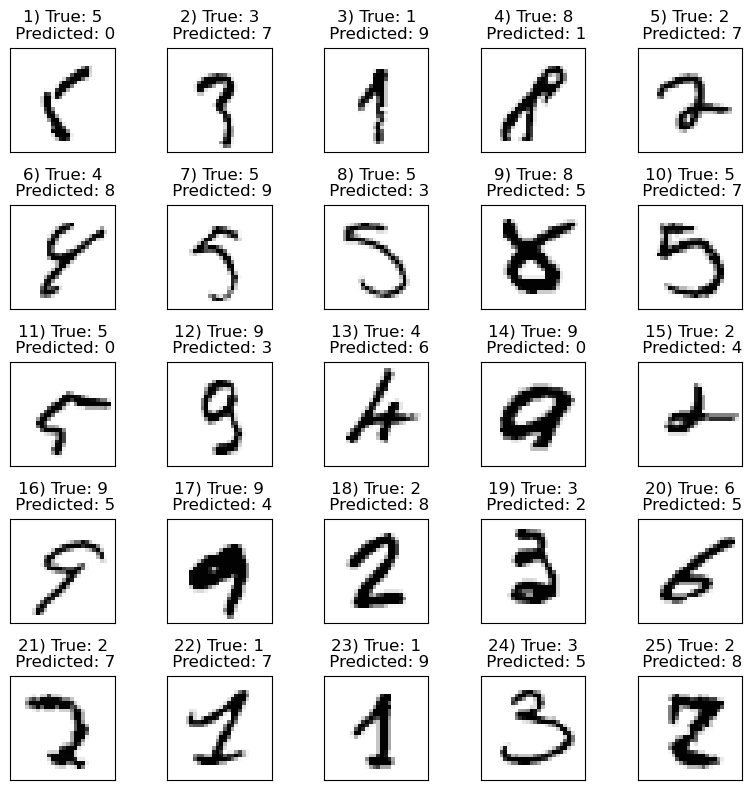

In [78]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()

plt.show()